# Цель

Сравнение трех разобранных алгоритмов бустинга и подбор гиперпараметров для получения лучшего качества.
Использовать любой датасет для задачи классификации.

In [60]:
import time
import re
# from __future__ import print_function
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_union, make_pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler, LabelEncoder, MinMaxScaler,  Imputer, LabelBinarizer, OneHotEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV

import xgboost as xgb
# import lightgbm as lgb

%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 8)
pd.options.display.float_format = '{:.2f}'.format

import warnings
warnings.filterwarnings("ignore")

# Датасет

Описание:

Предскажите задержки вылета в 15 и более минут. Известно время вылета, авиакомпания-перевозчик, место вылета и назначения, а также расстояние между ними. Прогнозируемый признак – бинарный, целевая метрика – ROC AUC. 

https://www.kaggle.com/c/flight-delays-2017/overview

flight_delays_train.csv – обучающая выборка

flight_delays_test.csv – тестовая выборка

sample_submission.csv – пример файла посылки

Признаки:

- Month, DayofMonth, DayOfWeek, месяц, день месяца и день недели
- DepTime, время отправления
- UniqueCarrier, код перевозчика
- Origin, место вылета
- Dest, место назначения
- Distance, расстояние между аэропортами вылета и прилета
- dep_delayed_15min, просрочка вылета на 15 и более минут (целевой признак)


In [5]:
df = pd.read_csv('data/flight_delays_train.csv')
df.head(10)

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y
5,c-8,c-3,c-4,1918,NW,MEM,MCO,683,N
6,c-1,c-27,c-4,754,DL,PBI,LGA,1035,N
7,c-4,c-29,c-6,635,OH,MSP,CVG,596,N
8,c-7,c-28,c-5,735,AA,ONT,DFW,1189,N
9,c-6,c-20,c-2,2029,OO,DEN,PSC,853,N


# EDA

## 1. Анализ целевой переменной

Целевая переменная имеет бинарный характер и принимает значения из `{'Y','N'}`.

Посмотрим на балан этих значений:

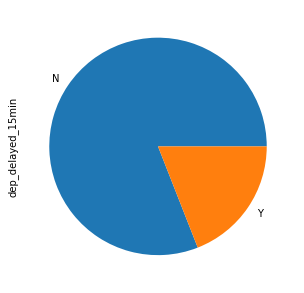

In [9]:
plt.figure(figsize=(6,5))
df['dep_delayed_15min'].value_counts().plot(kind='pie')

In [10]:
target_count = df['dep_delayed_15min'].value_counts()
print('Class N:', target_count[0])
print('Class Y:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

Class N: 80956
Class Y: 19044
Proportion: 4.25 : 1


Целевая переменная имеет невысокий дизбаланс `4 к 1`. Для улучшения результатов необходимо будет провести undersampling.

In [11]:
df['dep_delayed_15min'].unique()

array(['N', 'Y'], dtype=object)

Пропусков в целевой переменной нет.

## 2. Анализ признаков

In [13]:
df.drop('dep_delayed_15min', axis=1).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
Month            100000 non-null object
DayofMonth       100000 non-null object
DayOfWeek        100000 non-null object
DepTime          100000 non-null int64
UniqueCarrier    100000 non-null object
Origin           100000 non-null object
Dest             100000 non-null object
Distance         100000 non-null int64
dtypes: int64(2), object(6)
memory usage: 6.1+ MB


Значений 'NaN' в признаках нет. Датасет содержит 2 чсиловых признака и 6 категориальных.

Посмотрим уникальные значения на предмет замены значений различными символами.

In [24]:
columns = df.drop('dep_delayed_15min', axis=1).columns.tolist()
for column in columns:
    print(column)
    print('----------')
    print(df[column].unique())
    print('\r')

Month
----------
['c-8' 'c-4' 'c-9' 'c-11' 'c-10' 'c-1' 'c-7' 'c-6' 'c-5' 'c-3' 'c-12'
 'c-2']

DayofMonth
----------
['c-21' 'c-20' 'c-2' 'c-25' 'c-7' 'c-3' 'c-27' 'c-29' 'c-28' 'c-5' 'c-6'
 'c-10' 'c-19' 'c-26' 'c-14' 'c-22' 'c-9' 'c-31' 'c-4' 'c-16' 'c-18'
 'c-30' 'c-1' 'c-24' 'c-15' 'c-17' 'c-8' 'c-12' 'c-13' 'c-11' 'c-23']

DayOfWeek
----------
['c-7' 'c-3' 'c-5' 'c-6' 'c-4' 'c-2' 'c-1']

DepTime
----------
[1934 1548 1422 ... 2530  219 2415]

UniqueCarrier
----------
['AA' 'US' 'XE' 'OO' 'WN' 'NW' 'DL' 'OH' 'AS' 'UA' 'MQ' 'CO' 'EV' 'DH'
 'YV' 'F9' 'AQ' 'TZ' 'HP' 'B6' 'FL' 'HA']

Origin
----------
['ATL' 'PIT' 'RDU' 'DEN' 'MDW' 'MEM' 'PBI' 'MSP' 'ONT' 'BDL' 'PHX' 'LAS'
 'DFW' 'DSM' 'CMH' 'ORF' 'SLC' 'CLT' 'GSO' 'IAD' 'SMF' 'FLL' 'DAL' 'ORD'
 'ITO' 'SAN' 'ROA' 'LGA' 'SFO' 'GSP' 'SEA' 'DAB' 'SJC' 'LIT' 'LAX' 'OAK'
 'COS' 'OKC' 'GRR' 'JFK' 'BOI' 'MCI' 'BWI' 'BHM' 'CRP' 'BOS' 'SAT' 'PHL'
 'STL' 'CIC' 'AUS' 'IAH' 'COD' 'HNL' 'RNO' 'BNA' 'TPA' 'MIA' 'EVV' 'PNS'
 'EWR' 'RSW' 'ANC' 'SNA' 

In [84]:
df.isnull().sum()

Month                0
DayofMonth           0
DayOfWeek            0
DepTime              0
UniqueCarrier        0
Origin               0
Dest                 0
Distance             0
dep_delayed_15min    0
dtype: int64

Данные не содержат пропусков.

## 3. Преобразование признаков

Преобразуем категориальные признаки

In [76]:
# lepf = LabelEncoderPipelineFriendly()
# lepf.fit_transform(df['Month'])
import re

regex = re.compile(r"\w+-(\d+)", re.IGNORECASE)

df2 = df.copy(deep=True)
df2['Month'] = df['Month'].apply(lambda x: int(regex.findall(x)[0]))
df2['DayofMonth'] = df['DayofMonth'].apply(lambda x: int(regex.findall(x)[0]))
df2['DayOfWeek'] = df['DayOfWeek'].apply(lambda x: int(regex.findall(x)[0]))

le = LabelEncoder()
df2['UniqueCarrier'] = le.fit_transform(df2['UniqueCarrier'])
df2['Origin'] = le.fit_transform(df2['Origin'])
df2['Dest'] = le.fit_transform(df2['Dest'])

df2['dep_delayed_15min'] = df2['dep_delayed_15min'].map({'N':0,'Y':1})

In [97]:
def importance_plot(df, model_coef, figsize=(10,6)):
    featureImportance = pd.DataFrame({"feature": df.drop('dep_delayed_15min',axis=1).columns, 
                                  "importance": model_coef})
    
    featureImportance.set_index('feature', inplace=True)
    featureImportance.sort_values(["importance"], ascending=False, inplace=True)
    featureImportance["importance"].plot('bar', figsize=figsize);

def randomized_cv(model, param_grid, x_train, y_train):
    grid_search = RandomizedSearchCV(model, param_grid, cv=5, scoring='accuracy')
    t_start = time.time()
    grid_search.fit(x_train, y_train)
    t_end = time.time()
    print('model {} best accuracy score is {}'.format(model.__class__.__name__, grid_search.best_score_))
    print('time for training is {} seconds'.format(t_end - t_start))
    print(grid_search.best_score_)
    return grid_search.best_estimator_

In [77]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df2.drop(['dep_delayed_15min'], axis=1), 
    df2['dep_delayed_15min'], 
    stratify=df['dep_delayed_15min'],
    random_state=42
)

# Создание модели

## 1. Baseline

В качестве `baseline` используем линейную регрессию.

In [93]:
from sklearn.linear_model import LogisticRegressionCV

searchCV = LogisticRegressionCV(
    Cs=list(np.power(10.0, np.arange(-10, 10)))
    ,penalty='l2'
    ,scoring='roc_auc'
    ,cv=5
    ,random_state=777
    ,max_iter=10000
    ,fit_intercept=True
    ,solver='newton-cg'
    ,tol=10
)
searchCV.fit(X_train, y_train)

print ('Max auc_roc:', searchCV.scores_[1].max())

Max auc_roc: 0.6889207355624698


In [120]:
accuracity = searchCV.score(X_test, y_test)
print("Accuracity: {}".format(accuracity))

Accuracity: 0.681549486991095


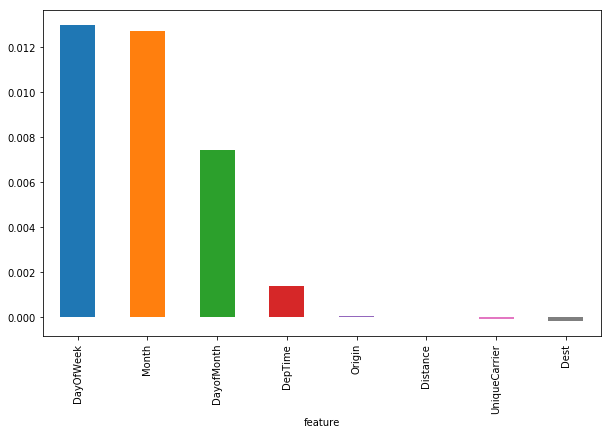

In [106]:
importance_plot(df2, searchCV.coef_[0])

## 2. XGB

In [79]:
import xgboost as xgb

param_grid = {
    'max_depth': [2, 3, 4],
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.025]
}
xgb = randomized_cv(xgb.XGBClassifier(), param_grid, x_train=X_train,y_train=y_train)

model XGBClassifier best accuracy score is 0.8128666666666666
time for training is 186.2315378189087 seconds
0.8128666666666666


In [117]:
accuracity = xgb.score(X_test, y_test)
print("Accuracity: {}".format(accuracity))

Accuracity: 0.81256


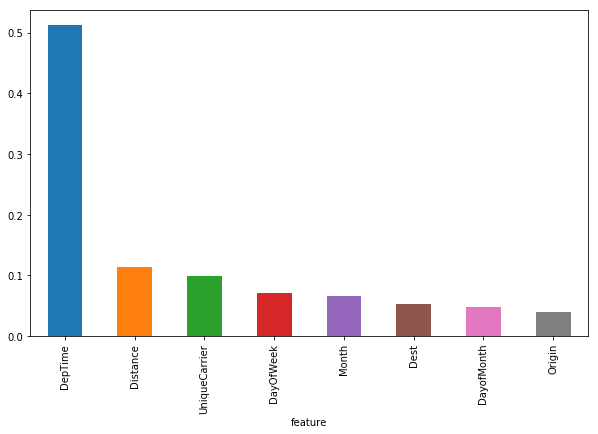

In [116]:
importance_plot(df2, xgb.feature_importances_)

## 3. CatBoost

In [81]:
from catboost import CatBoostClassifier
param_grid = {
    'iterations': [2, 3, 4, 5],
    'depth': [2, 3, 4, 5],
    'learning_rate': [1, 0.1, 0.01, 0.001]
}
cbm = randomized_cv(CatBoostClassifier(), param_grid,x_train=X_train,y_train=y_train)

0:	learn: 0.6537221	total: 69.2ms	remaining: 138ms
1:	learn: 0.6211496	total: 78.1ms	remaining: 39.1ms
2:	learn: 0.5945352	total: 94.8ms	remaining: 0us
0:	learn: 0.6536466	total: 15.4ms	remaining: 30.8ms
1:	learn: 0.6209884	total: 27.1ms	remaining: 13.6ms
2:	learn: 0.5943059	total: 37.7ms	remaining: 0us
0:	learn: 0.6534932	total: 15.3ms	remaining: 30.5ms
1:	learn: 0.6211229	total: 29.6ms	remaining: 14.8ms
2:	learn: 0.5948102	total: 43.1ms	remaining: 0us
0:	learn: 0.6541509	total: 15.5ms	remaining: 31ms
1:	learn: 0.6215318	total: 26.5ms	remaining: 13.2ms
2:	learn: 0.5945984	total: 36.6ms	remaining: 0us
0:	learn: 0.6541008	total: 30ms	remaining: 60ms
1:	learn: 0.6215212	total: 57.3ms	remaining: 28.7ms
2:	learn: 0.5945720	total: 66.9ms	remaining: 0us
0:	learn: 0.6537803	total: 10.9ms	remaining: 21.8ms
1:	learn: 0.6222462	total: 22.9ms	remaining: 11.5ms
2:	learn: 0.5961542	total: 30.7ms	remaining: 0us
0:	learn: 0.6537290	total: 7.46ms	remaining: 14.9ms
1:	learn: 0.6219692	total: 14.6ms	rem

In [118]:
accuracity = cbm.score(X_test, y_test)
print("Accuracity: {}".format(accuracity))

Accuracity: 0.8122


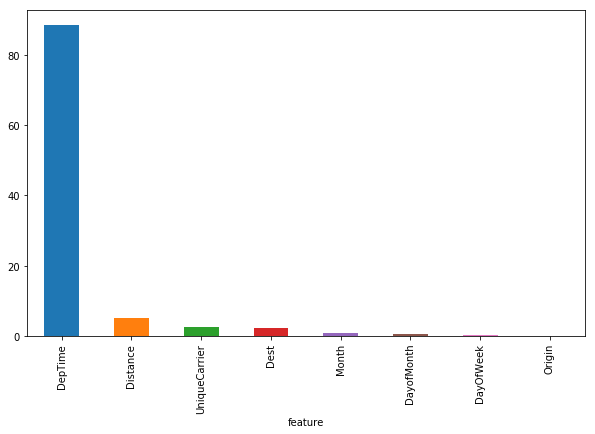

In [114]:
importance_plot(df2, cbm.feature_importances_)

## 3. GBC

In [83]:
from sklearn.ensemble import GradientBoostingClassifier

param_grid = {
    'max_depth': [2, 3, 4],
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.025]
}
gbc = randomized_cv(GradientBoostingClassifier(), param_grid,x_train=X_train,y_train=y_train)

model GradientBoostingClassifier best accuracy score is 0.8141066666666666
time for training is 227.8493161201477 seconds
0.8141066666666666


In [119]:
accuracity = gbc.score(X_test, y_test)
print("Accuracity: {}".format(accuracity))

Accuracity: 0.8136


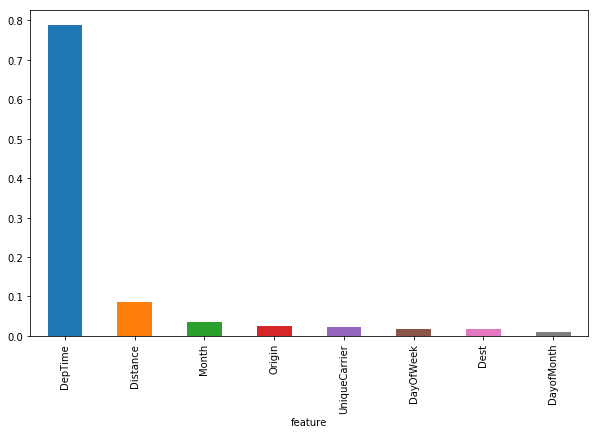

In [115]:
importance_plot(df2, gbc.feature_importances_)

# Выводы

- Лучшие результаты показала модель `XGBClassifier` с accuracity = 0.81256.
- Наиболее важный признак модели выделелили: `DepTime`.